<a href="https://colab.research.google.com/github/dnarna909/5201_Term-Project/blob/main/Term%20Project_Neural%20Network_numeric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New Section

In [5]:
packageList <- c("dplyr", "keras","jpeg", "ggplot2", "rio")
for(package in packageList){
  if(!require(package,character.only = TRUE)){
    install.packages(package);require(package,character.only = TRUE);}
    }

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: keras

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘keras’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘here’, ‘png’, ‘config’, ‘tfautograph’, ‘reticulate’, ‘tensorflow’, ‘tfruns’, ‘zeallot’


Loading required package: keras

Loading required package: jpeg

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘jpeg’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: jpeg

Loading required package: ggplot2

Loading required package: rio

Wa

In [3]:
df <- read.csv("NHANES for ML.csv", row.names=1)
# table(df$HbA1c)
colnames(df)
table(df$diagnosed.diabetes)
table(df$diagnosed.kidney.disease)
table(df$diagnosed.diabetes, df$diagnosed.kidney.disease, dnn = list("diabetes", "kidney.disease"))
table(df$KIQ022)
table(df$DIQ010)
# table(df$URDACT)
table(df$PA_level)

[1] "Study.ID"                 "RIAGENDR"                
 [3] "RIDAGEYR"                 "DMDEDUC2"                
 [5] "INDFMPIR"                 "HbA1c"                   
 [7] "DIQ010"                   "diagnosed.diabetes"      
 [9] "KIQ022"                   "URDACT"                  
[11] "diagnosed.kidney.disease" "Work.VPA.MIN"            
[13] "Recreational.VPA.MIN"     "Work.MPA.MIN"            
[15] "Recreational.MIN"         "Transport.MIN"           
[17] "total_MIN"                "PA_level"                
[19] "BMXWT"                    "BMXBMI"


    0     1 
21788  4104 


    0     1 
25047   845 

        kidney.disease
diabetes     0     1
       0 21292   496
       1  3755   349


    1     2 
  845 25047 


    1     2     3 
 3452 21788   652 


     Active    Inactive Very Active 
       3291       10756       11845 

[1] 25892    20

Warning message:
“`add_rownames()` was deprecated in dplyr 1.0.0.
Please use `tibble::rownames_to_column()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


[1] "Study.ID"                 "RIAGENDR"                
 [3] "RIDAGEYR"                 "DMDEDUC2"                
 [5] "INDFMPIR"                 "HbA1c"                   
 [7] "DIQ010"                   "diagnosed.diabetes"      
 [9] "KIQ022"                   "URDACT"                  
[11] "diagnosed.kidney.disease" "Work.VPA.MIN"            
[13] "Recreational.VPA.MIN"     "Work.MPA.MIN"            
[15] "Recreational.MIN"         "Transport.MIN"           
[17] "total_MIN"                "BMXWT"                   
[19] "BMXBMI"

[1] "PA_level"

[1] 0

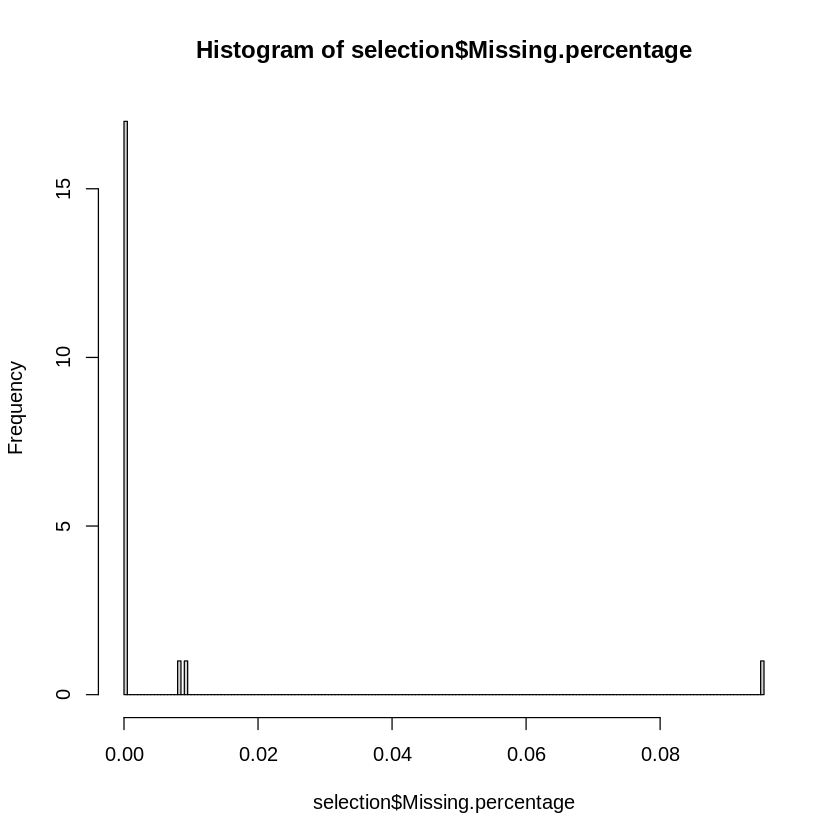

In [6]:
dim(df)
# create selection dataframe for columns to avoid NA
selection <- sapply(df, function(xx) {c("Missing.numbers" = sum(is.na(xx)), 
                             "Missing.percentage" = sum(is.na(xx))/nrow(df),
                             "Is.numeric" = is.numeric(xx),  
                             "Median.values" = ifelse( is.numeric(xx), median(xx, na.rm = TRUE), 999999999) ) }) %>% 
  t %>% as.data.frame() %>% add_rownames 
hist(selection$Missing.percentage, breaks = 200)

select.names <- subset(selection, Missing.percentage < 0.1 & Is.numeric == 1)$rowname # set 10% as the cutting line to select columns
select.names
character.names <- subset(selection, Is.numeric == 0)$rowname 
character.names
df1 <- df[, c(character.names, select.names)] 

# delete rows with NA vaules
df2 <- df1
for (col in select.names) {df2 <- subset(df2, !is.na(df2[[col]]))}
sum(is.na(df2))

In [7]:
# Step 1.Set up the data
# 1/3 is test and the rest are training
n <- nrow(df2)
set.seed (13)
ntest <- trunc(n / 3)
testid <- sample (1:n, ntest)

In [36]:
# Step 2.Create x and y
x <- model.matrix(HbA1c ~ . - 1, data = df2) %>% scale () # long time running
dim(x)
x_train <- array(x[-testid , ], dim = c(dim(x[-testid , ])[1], dim(x[-testid , ])[2]))
x_test <- array(x[testid , ], dim = c(dim(x[testid , ])[1], dim(x[testid , ])[2]))

y <- df2$diagnosed.diabetes
g_train <- y[-testid]
g_test <- y[testid]
y_train <- to_categorical(g_train, length(unique(y)))
y_test <- to_categorical(g_test , length(unique(y)))


[1] 23217    21

In [37]:
#Step 3.Linear regression
lfit <- lm(HbA1c ~ ., data = df2[-testid , ])
lpred <- predict(lfit , df2[testid , ])
with(df2[testid , ], mean(abs(lpred - HbA1c))) # method 2

Warning message in predict.lm(lfit, df2[testid, ]):
“prediction from a rank-deficient fit may be misleading”


[1] 0.4721138

In [54]:
modnn <- keras_model_sequential () %>%
  layer_dense(units = round(max(x)), activation = "relu",
              input_shape = ncol(x)) %>%
  layer_dropout(rate = 0.4)  %>%
  layer_dense(units = round(max(x))/2, activation = "relu" ) %>%
  layer_dropout(rate = 0.3)  %>%
  layer_dense(units = 1)

modnn %>% compile(loss = "mse",
                  optimizer = optimizer_rmsprop (),
                  metrics = list("mean_absolute_error")
)

In [51]:
history <- modnn %>% fit(
  x_train, y_train, epochs = 150, batch_size = (max(x_train)/2),
  validation_data = list(x_test , y_test)
)

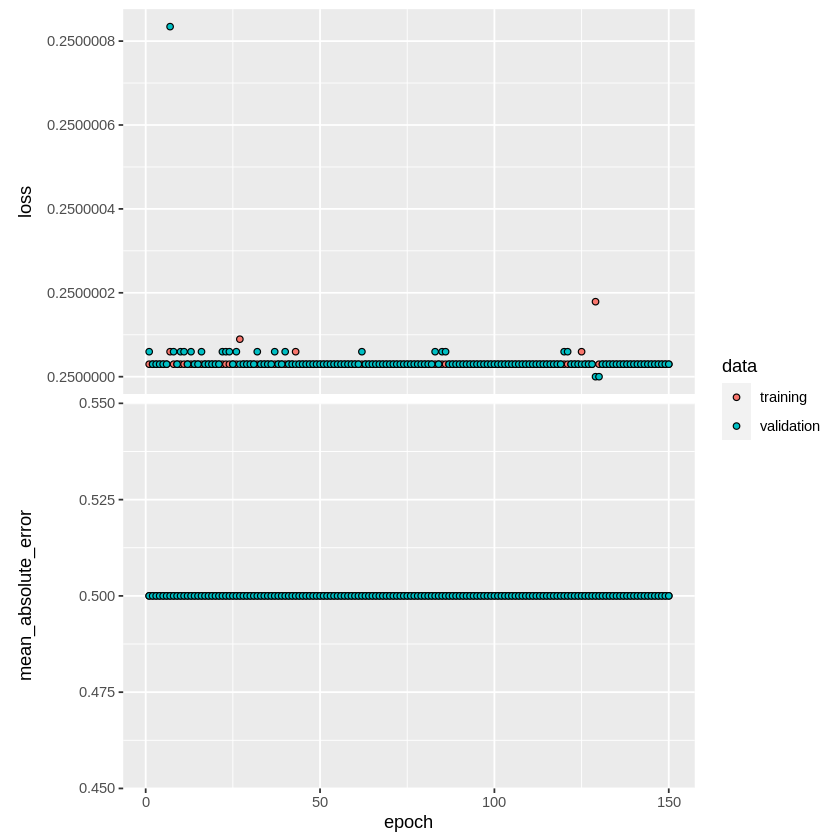

In [52]:
plot(history , smooth = FALSE)

In [53]:
npred <- predict(modnn , x[testid , ])
mean(abs(y[testid] - npred))

npred <- predict(modnn , x[-testid , ])
mean(abs(y[-testid] - npred))

[1] 0.4996526

[1] 0.4996568